# Pokemon wiki recommendation system
The project is about recommending pokemon articles from https://bulbapedia.bulbagarden.net/wiki/Main_Page, based on the provided pokemons (that the user may have read about, be interested in, etc.).

Project files can be found on GitHub - https://github.com/bujowskis/pokemon-wiki-recommender.

# Scrapping

We will be using scrapy to obtain the data from Bulbapedia.

Scrapy project files can be found on GitHub - https://github.com/bujowskis/pokemon-wiki-recommender. If you wish to run the scrapper in Google Colab, you can upload them to the runtime and run the below commands.

If you don't wish to run the scrapper yourself, you can skip to [Loading scrapped and preprocessed data](#loading_preprocessed).

The general idea for scraping the content is that there are two types of pages holding pokemon data we're interested in:
- list of content page
  - contains links to articles on individual pokemons
  - may (or may not) contain link to next list of content page - this is due to the fact that there's a limit on the amount of pokemons that may be displayed on a single list of content page (at the time of writing this, 200 pokemons/page), so the rest is rendered on a next page
- individual article page - contains info on the individual pokemon

So, to scrap all the pokemon data, the crawler works as follows:
1. We start from the following page, which lists first N pokemons - https://bulbapedia.bulbagarden.net/wiki/Category:Pok%C3%A9mon
2. We extract the links to individual articles and parse their content (select all paragraphs, extract, and join their text)
3. We check if there's a next list page to go to
  - If so, we parse the next list page in the same way as the first one (step 2)
  - If not, it means the crawler covered all list pages and articles - crawling complete

In [ ]:
!pip install scrapy

In [ ]:
!scrapy startproject ir_project1_wiki_recommender

Error: Module 'ir_project1_wiki_recommender' already exists


In [ ]:
%cd /content/ir_project1_wiki_recommender

/content/ir_project1_wiki_recommender


In [ ]:
!rm output.json
!scrapy crawl pokemon_spider -o output.json

rm: cannot remove 'output.json': No such file or directory
2023-11-16 22:38:24 [scrapy.utils.log] INFO: Scrapy 2.11.0 started (bot: ir_project1_wiki_recommender)
2023-11-16 22:38:24 [scrapy.utils.log] INFO: Versions: lxml 4.9.3.0, libxml2 2.10.3, cssselect 1.2.0, parsel 1.8.1, w3lib 2.1.2, Twisted 22.10.0, Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0], pyOpenSSL 23.3.0 (OpenSSL 3.1.4 24 Oct 2023), cryptography 41.0.5, Platform Linux-5.15.120+-x86_64-with-glibc2.35
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/scrapy/spiderloader.py", line 87, in load
    return self._spiders[spider_name]
KeyError: 'pokemon_spider'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/scrapy", line 8, in <module>
    sys.exit(execute())
  File "/usr/local/lib/python3.10/dist-packages/scrapy/cmdline.py", line 161, in execute
    _run_print_help(parser, _run_command, cmd, args, opts)


In [ ]:
import pandas as pd

df = pd.read_json('output.json')
print(len(df))  # fits the "at least 1,000 articles" threshold
display(df)

FileNotFoundError: ignored

In [ ]:
df.to_csv("pokemons_scrapped.csv")

# Preprocessing

Since we will be using sklearn `TfidfVectorizer` which already handles a lot of preprocessing (stopwords elimination, tokenization, etc.), we preprocess the data by simply filtering the scrapped text to only contain alphanumeric characters.

We tried applying stemming and lemmatization, but the problem is that the articles often contain a substantial number of pokemon-specific vocabulary, and these words ended up hurt by these methods. That is why we decided to keep things simple with only alphanumeric filter.

**NOTE** - we can relatively safely remove the Japanese characters, since there's always the English translation right next to them.



In [ ]:
import re

def preprocess_text(text):
  text_alphanumeric = re.sub(r'[^A-Za-z0-9\s]', '', text)
  return {'alphanumeric': text_alphanumeric}

In [ ]:
preprocessed_df = pd.concat([df, pd.DataFrame(list(df['text'].apply(preprocess_text)))], axis=1)
display(preprocessed_df)

NameError: ignored

In [ ]:
preprocessed_df.to_csv("pokemons_preprocessed.csv")

In [ ]:
# saving project files
!zip -r /content/ir_project_1.zip /content/ir_project1_wiki_recommender
from google.colab import files
files.download("/content/ir_project_1.zip")

# Recommendation

For the recommendation system, we use sklearn `TfidfVectorizer` to calculate the document TF-IDF features vectors. It does the following:
- lowercase all words - this way mistakes in capitalization do not affect the algorithm
- remove english stop words - stop words such as "the", "like", "and", "a", etc. are irrelevant from this task point of view, therefore we can remove them for better performance and accuracy
- with `max_df=0.9, min_df=1`, we respectively:
  - remove words that appear in more than 90% documents - this intends to cut off corpus(pokemon)-specific stop words
  - remove words that appear in only a single document, since this doesn't help us in scoring them against each other
- Tokenization - tokenizing text into individual words
- Counting Term Frequencies (TF) - counting the number of times each term (word) appears
- Calculating Inverse Document Frequency (IDF) - IDF measures how important a term is across the entire corpus

Once we obtain the TF-IDF vectors, we compute the cosine similarity between the documents. Then the process of obtaining the recommendations, given pokemons to base the recommendation on, is as follows:
- let n be the number of top articles the user wants to be recommended
- let "rest of pokemons" be all the pokemons except the ones we base the recommendation on
- for all rest of pokemons obtain the individual scores (cosine similarities) to all pokemons we base the recommendation on
- calculate the combined score (similarity) using all individual scores - this is a simple mean of all individual scores
  - **NOTE** - the individual scores must be normalized to ensure all individual recommendations have equal contribution to the combined score, regardles of the actual individual score value - see [normalizing the score](#normalizing_combined) and`get_pokemon_recommendations_normalized`, the individual scores are normalized
- select top n articles according to the combined score - this is our recommendation

<a name="loading_preprocessed"></a>
## NOTE - Loading scrapped and preprocessed data
If you want to use the recommender without running the scrapper, you may upload the preprocessed data from the csv (available on GitHub):

In [2]:
import pandas as pd
preprocessed_df = pd.read_csv('pokemons_preprocessed.csv')  # upload to runtime
display(preprocessed_df)

,Unnamed: 0,url,name,text,alphanumeric
0,0,https://bulbapedia.bulbagarden.net/wiki/Abomas...,Abomasnow,Abomasnow (Japanese: ユキノオー Yukinooh) is a dual...,Abomasnow Japanese Yukinooh is a dualtype Gra...
1,1,https://bulbapedia.bulbagarden.net/wiki/Arctov...,Arctovish,Arctovish (Japanese: ウオチルドン Uochilldon) is a d...,Arctovish Japanese Uochilldon is a dualtype W...
2,2,https://bulbapedia.bulbagarden.net/wiki/Arctoz...,Arctozolt,Arctozolt (Japanese: パッチルドン Patchilldon) is a ...,Arctozolt Japanese Patchilldon is a dualtype ...
3,3,https://bulbapedia.bulbagarden.net/wiki/Arroku...,Arrokuda,Arrokuda (Japanese: サシカマス Sasikamasu) is a Wat...,Arrokuda Japanese Sasikamasu is a Watertype P...
4,4,https://bulbapedia.bulbagarden.net/wiki/Ariado...,Ariados,Ariados (Japanese: アリアドス Ariados) is a dual-ty...,Ariados Japanese Ariados is a dualtype BugPoi...
...,...,...,...,...,...
1016,1016,https://bulbapedia.bulbagarden.net/wiki/Aegisl...,Aegislash,Aegislash (Japanese: ギルガルド Gillgard) is a dual...,Aegislash Japanese Gillgard is a dualtype Ste...
1017,1017,https://bulbapedia.bulbagarden.net/wiki/Aggron...,Aggron,Aggron (Japanese: ボスゴドラ Bossgodora) is a dual-...,Aggron Japanese Bossgodora is a dualtype Stee...
1018,1018,https://bulbapedia.bulbagarden.net/wiki/Aeroda...,Aerodactyl,Aerodactyl (Japanese: プテラ Ptera) is a dual-typ...,Aerodactyl Japanese Ptera is a dualtype RockF...
1019,1019,https://bulbapedia.bulbagarden.net/wiki/Abra_(...,Abra,Abra (Japanese: ケーシィ Casey) is a Psychic-type ...,Abra Japanese Casey is a Psychictype Pokmon i...


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


def display_all_pokemons():
  """
  Displays all pokemons and links to their respective wiki pages
  """
  display(preprocessed_df[['name', 'url']])


def get_index_of_pokemon(pokemon: str):
  try:
      return preprocessed_df[preprocessed_df['name'] == pokemon].index[0]
  except IndexError:
    print(f"{pokemon} not found in the database. Please check the available pokemons using display_all_pokemons() function.")
    return None


def get_pokemon_name(index: int):
  try:
    return preprocessed_df.loc[index, 'name']
  except KeyError:
    print(f"Pokemon at index {index} not found in the database. Please check the available pokemons using display_all_pokemons() function.")
    return None


def pretty_print_similarity(similarity: float):
  return f'{similarity*100:.2f}%'


# 0.9 - try cut out corpus-specific stopwords
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=1)
document_vectors = vectorizer.fit_transform(preprocessed_df['alphanumeric'])

cosine_sim_matrix = cosine_similarity(document_vectors, document_vectors)
pd.DataFrame(cosine_sim_matrix).to_csv('cosine_sim_matrix.csv')

all_pokemons = set(preprocessed_df['name'])
all_pokemons_indices = {get_index_of_pokemon(pokemon) for pokemon in all_pokemons}


def get_pokemon_recommendations(pokemons: set, top_n_recommendations: int = 5):
  """
  Given a set of pokemons from https://bulbapedia.bulbagarden.net/wiki/
  the user already read about, recommends top n similar pokemons to read about
  next
  """
  valid_pokemons = all_pokemons.intersection(pokemons)
  for pokemon in pokemons:
    if pokemon not in valid_pokemons:
      print(f'Pokemon "{pokemon}" not found in bulbapedia.\nYou may view all available pokemons by using display_all_pokemons() function.')
  if len(valid_pokemons) == 0:
    print('No valid pokemons to base the recommendation on. Please check the available pokemons using display_all_pokemons() function, adjust the pokemons, and try again.')
    return
  print(f'Valid pokemons to base the recommendation on: {valid_pokemons}')

  valid_pokemons_indexes = {get_index_of_pokemon(pokemon) for pokemon in valid_pokemons}
  pokemons_to_compare_indexes = all_pokemons_indices - valid_pokemons_indexes

  # calculate individual scores
  individual_scores = dict()
  for pokemon in pokemons_to_compare_indexes:
    individual_scores[pokemon] = dict()
    for input_pokemon in valid_pokemons_indexes:
      individual_scores[pokemon][input_pokemon] = cosine_sim_matrix[pokemon][input_pokemon]

  # calculate combined score - simple mean of all scores
  combined_scores = {pokemon: sum(individual_scores[pokemon].values())/len(valid_pokemons_indexes) for pokemon in pokemons_to_compare_indexes}

  # select top n
  sorted_scores = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[:top_n_recommendations]

  # display top n, (with combined and individual scores), display snippet (first 50 chars?) of raw text, return dataframe???
  print(f'\nTop {top_n_recommendations} recommendations for pokemons to read about next, given you already read about {valid_pokemons}:')
  for recommended_pokemon_index, recommended_pokemon_combined_score in sorted_scores:
    print(f'***** *** Pokemon: {get_pokemon_name(recommended_pokemon_index)}')
    print(f'Similarity to all pokemons you read about: {pretty_print_similarity(recommended_pokemon_combined_score)}')
    print(f'Similarity to these pokemons individually:')
    for pokemon_index in valid_pokemons_indexes:
      print(f'- {get_pokemon_name(pokemon_index)}: {pretty_print_similarity(individual_scores[recommended_pokemon_index][pokemon_index])}')
    print(f'Snippet of the article on bulbapedia:\n{preprocessed_df.iloc[recommended_pokemon_index]["text"][:200]}...')
    print(f'Read the article here - url: {preprocessed_df.iloc[recommended_pokemon_index]["url"]}')
    print()

  return {get_pokemon_name(index): score for index, score in sorted_scores}

<a name="normalizing_combined"></a>
The problem with this approach is that the score is non-normalized and a pokemon with relatively high similarity and a pokemon with relatively low one may throw the recommendations off.

Let A, B, C, D, E be all pokemons. Consider the following example scores for pokemons C, D, E, given we base the recommendation on A, B:
- pokemon C - A: 0.74, B: 0.08
- pokemon D - A: 0.32, B: 0.32
- pokemon E - A: 0.24, B: 0.24

The scores would be as follows:
- pokemon C - 0.41
- pokemon D - 0.32
- pokemon E - 0.24

Pokemon C would score first, despite pokemon D and E score 4 and 3 times higher on pokemon B. If we normalized (rounded to :.2f precision):
- pokemon C - A: 1.00, B: 0.25
- pokemon D - A: 0.43, B: 1.00
- pokemon E - A: 0.32, B: 0.75

The scores are as follows:
- pokemon C - 0.625
- pokemon D - 0.715
- pokemon E - 0.535

Pokemon D would score first now, and pokemon E would not fall as much short from pokemon C. Normalizing the scores helps make the recommendation more just, all individual scores contribute equally.

In [4]:
def get_pokemon_recommendations_normalized(pokemons: set, top_n_recommendations: int = 5):
  """
  Given a set of pokemons from https://bulbapedia.bulbagarden.net/wiki/
  the user already read about, recommends top n similar pokemons to read about
  next
  """
  valid_pokemons = all_pokemons.intersection(pokemons)
  for pokemon in pokemons:
    if pokemon not in valid_pokemons:
      print(f'Pokemon "{pokemon}" not found in bulbapedia.\nYou may view all available pokemons by using display_all_pokemons() function.')
  if len(valid_pokemons) == 0:
    print('No valid pokemons to base the recommendation on. Please check the available pokemons using display_all_pokemons() function, adjust the pokemons, and try again.')
    return
  print(f'Valid pokemons to base the recommendation on: {valid_pokemons}')

  valid_pokemons_indexes = {get_index_of_pokemon(pokemon) for pokemon in valid_pokemons}
  pokemons_to_compare_indexes = all_pokemons_indices - valid_pokemons_indexes

  # calculate individual scores
  individual_scores = dict()
  for pokemon in pokemons_to_compare_indexes:
    individual_scores[pokemon] = dict()
    for input_pokemon in valid_pokemons_indexes:
      individual_scores[pokemon][input_pokemon] = cosine_sim_matrix[pokemon][input_pokemon]

  # normalize
  scores_df = pd.DataFrame.from_dict(individual_scores, orient='index')
  for pokemon in valid_pokemons_indexes:
    max_value = scores_df[pokemon].max()
    scores_df[pokemon] = scores_df[pokemon] / max_value

  # calculate combined score - simple mean of all scores
  scores_df['combined'] = scores_df.mean(axis=1)

  # select top n
  sorted = scores_df.sort_values(by='combined', ascending=False)
  selected = sorted.head(top_n_recommendations)

  # display top n, (with combined and individual scores), display snippet (first 50 chars?) of raw text, return dataframe???
  print(f'\nTop {top_n_recommendations} recommendations for pokemons to read about next, given you already read about {valid_pokemons}:\n')
  for recommended_pokemon_index, row in selected.iterrows():
    print(f'***** *** Pokemon: {get_pokemon_name(recommended_pokemon_index)}')
    print(f'Combined score given all pokemons you read about: {pretty_print_similarity(row["combined"])}')
    print(f'Similarity to these pokemons individually:')
    for pokemon_index in valid_pokemons_indexes:
      print(f'- {get_pokemon_name(pokemon_index)}: {pretty_print_similarity(individual_scores[recommended_pokemon_index][pokemon_index])}')
    print(f'Snippet of the article on bulbapedia:\n{preprocessed_df.iloc[recommended_pokemon_index]["text"][:200]}...')
    print(f'Read the article here - url: {preprocessed_df.iloc[recommended_pokemon_index]["url"]}')
    print()

  return selected

# Using the recommender

## Search all pokemons

In [5]:
print("NOTE - in colab, useful to Convert to interactive table")
display_all_pokemons()

NOTE - in colab, useful to Convert to interactive table


,name,url
0,Abomasnow,https://bulbapedia.bulbagarden.net/wiki/Abomas...
1,Arctovish,https://bulbapedia.bulbagarden.net/wiki/Arctov...
2,Arctozolt,https://bulbapedia.bulbagarden.net/wiki/Arctoz...
3,Arrokuda,https://bulbapedia.bulbagarden.net/wiki/Arroku...
4,Ariados,https://bulbapedia.bulbagarden.net/wiki/Ariado...
...,...,...
1016,Aegislash,https://bulbapedia.bulbagarden.net/wiki/Aegisl...
1017,Aggron,https://bulbapedia.bulbagarden.net/wiki/Aggron...
1018,Aerodactyl,https://bulbapedia.bulbagarden.net/wiki/Aeroda...
1019,Abra,https://bulbapedia.bulbagarden.net/wiki/Abra_(...


## Use the recommender system

In [6]:
# Adjust the set of pokemons based off which you want the recommendations
pokemons = {
    'Pikachu',
    'Geodude',
    'Diglett'
}
# Adjust the number of pokemons to be recommended
pokemons_to_recommend = 5

recommendations = get_pokemon_recommendations_normalized(pokemons, pokemons_to_recommend)

Valid pokemons to base the recommendation on: {'Pikachu', 'Diglett', 'Geodude'}

Top 5 recommendations for pokemons to read about next, given you already read about {'Pikachu', 'Diglett', 'Geodude'}:

***** *** Pokemon: Graveler
Combined score given all pokemons you read about: 44.32%
Similarity to these pokemons individually:
- Diglett: 4.55%
- Pikachu: 3.85%
- Geodude: 18.07%
Snippet of the article on bulbapedia:
Graveler (Japanese: ゴローン Golone) is a dual-type Rock/Ground Pokémon introduced in Generation I.
 It evolves from Geodude starting at level 25 and evolves into Golem when traded or when exposed to a Li...
Read the article here - url: https://bulbapedia.bulbagarden.net/wiki/Graveler_(Pok%C3%A9mon)

***** *** Pokemon: Golem
Combined score given all pokemons you read about: 43.33%
Similarity to these pokemons individually:
- Diglett: 3.82%
- Pikachu: 3.13%
- Geodude: 18.71%
Snippet of the article on bulbapedia:
Golem (Japanese: ゴローニャ Golonya) is a dual-type Rock/Ground Pokémon i

## Evaluation of the system - expert view

All the pokemon in this group are starters from different generations - 2 grass type and 1 fire type. The recommendations include their evolutions as well as other starter pokemons from various generations, icnluding water type. This shows that the alorithm focuses not only on the type, but also on the context.


In [7]:
get_pokemon_recommendations_normalized({'Chikorita', 'Bulbasaur', 'Tepig'}, 10)

Valid pokemons to base the recommendation on: {'Bulbasaur', 'Tepig', 'Chikorita'}

Top 10 recommendations for pokemons to read about next, given you already read about {'Bulbasaur', 'Tepig', 'Chikorita'}:

***** *** Pokemon: Bayleef
Combined score given all pokemons you read about: 37.41%
Similarity to these pokemons individually:
- Tepig: 1.69%
- Chikorita: 44.53%
- Bulbasaur: 2.85%
Snippet of the article on bulbapedia:
Bayleef (Japanese: ベイリーフ Bayleaf) is a Grass-type Pokémon introduced in Generation II.
 It evolves from Chikorita starting at level 16 and evolves into Meganium starting at level 32.
 Bayleef is a qua...
Read the article here - url: https://bulbapedia.bulbagarden.net/wiki/Bayleef_(Pok%C3%A9mon)

***** *** Pokemon: Ivysaur
Combined score given all pokemons you read about: 37.13%
Similarity to these pokemons individually:
- Tepig: 2.07%
- Chikorita: 2.59%
- Bulbasaur: 37.02%
Snippet of the article on bulbapedia:
Ivysaur (Japanese: フシギソウ Fushigisou) is a dual-type Grass/P

,302,901,942,combined
981,0.045334,1.000000,0.076984,0.374106
658,0.055700,0.058168,1.000000,0.371289
479,1.000000,0.038403,0.044830,0.361078
372,0.597641,0.112173,0.124315,0.278043
792,0.749022,0.033553,0.051105,0.277893
242,0.039925,0.057136,0.610223,0.235761
509,0.460224,0.080354,0.120333,0.220304
277,0.096797,0.358458,0.182029,0.212428
355,0.090957,0.092436,0.427139,0.203511
25,0.104133,0.327339,0.149888,0.193786


The next pair of pokemon is Metapod and Kakuna. Both of them are gen 1 bugs after their 1st evolution. Besides their other forms, one of the pokemon recomended is Cascoon - which perfectly captures the fact that they are all cocoons. The other 2 recommendiation, Pupitar and Forretress, are also cocoons/shells

In [17]:
get_pokemon_recommendations_normalized({'Metapod', 'Kakuna'}, 7)

Valid pokemons to base the recommendation on: {'Kakuna', 'Metapod'}

Top 7 recommendations for pokemons to read about next, given you already read about {'Kakuna', 'Metapod'}:

***** *** Pokemon: Beedrill
Combined score given all pokemons you read about: 59.86%
Similarity to these pokemons individually:
- Kakuna: 20.10%
- Metapod: 6.23%
Snippet of the article on bulbapedia:
Beedrill (Japanese: スピアー Spear) is a dual-type Bug/Poison Pokémon introduced in Generation I.
 It evolves from Kakuna starting at level 10. It is the final form of Weedle.
 Beedrill can Mega Evolve in...
Read the article here - url: https://bulbapedia.bulbagarden.net/wiki/Beedrill_(Pok%C3%A9mon)

***** *** Pokemon: Butterfree
Combined score given all pokemons you read about: 56.53%
Similarity to these pokemons individually:
- Kakuna: 2.62%
- Metapod: 31.59%
Snippet of the article on bulbapedia:
Butterfree (Japanese: バタフリー Butterfree) is a dual-type Bug/Flying Pokémon introduced in Generation I.
 It evolves from Meta

,649,542,combined
977,1.000000,0.197262,0.598631
937,0.130573,1.000000,0.565287
923,0.148962,0.832691,0.490826
926,0.416945,0.223172,0.320058
192,0.468800,0.072826,0.270813
123,0.075888,0.266606,0.171247
748,0.234005,0.096449,0.165227


Next we have Meowth, Skitty and Liepard - all are cat pokemon. The reccomendiations, besides cats and evolutions, include dogs and a fox, which are close to being a cat and also some of them share the dark type with Liepard. Cryogonal seems like an oulier at first, but there is a mention on Bulbapedia that it was involved in an anime episode as a member of team Plasma with Liepard, so this is likely the explanation as to why it made the list. Pikachu might be a true outlier, but it is not surprising as it is a mascot of the franchize and is probably involved in some way with all other pokemon - there is just too much data on pikachu making it more likely to find similarities to others.

In [19]:
get_pokemon_recommendations_normalized({'Meowth', 'Skitty', 'Liepard'}, 9)

Valid pokemons to base the recommendation on: {'Meowth', 'Liepard', 'Skitty'}

Top 9 recommendations for pokemons to read about next, given you already read about {'Meowth', 'Liepard', 'Skitty'}:

***** *** Pokemon: Persian
Combined score given all pokemons you read about: 42.13%
Similarity to these pokemons individually:
- Liepard: 3.43%
- Skitty: 2.21%
- Meowth: 34.16%
Snippet of the article on bulbapedia:
Persian (Japanese: ペルシアン Persian) is a Normal-type Pokémon introduced in Generation I.
 It evolves from Meowth starting at level 28.
 In Alola, Persian has a Dark-type regional form. It evolves from A...
Read the article here - url: https://bulbapedia.bulbagarden.net/wiki/Persian_(Pok%C3%A9mon)

***** *** Pokemon: Purrloin
Combined score given all pokemons you read about: 40.41%
Similarity to these pokemons individually:
- Liepard: 17.82%
- Skitty: 3.16%
- Meowth: 3.75%
Snippet of the article on bulbapedia:
Purrloin (Japanese: チョロネコ Choroneko) is a Dark-type Pokémon introduced in G

,598,390,550,combined
498,0.192326,0.071472,1.000000,0.421266
122,1.000000,0.102288,0.109928,0.404072
20,0.143564,1.000000,0.063737,0.402434
495,0.185954,0.060559,0.643744,0.296752
860,0.581273,0.024207,0.051208,0.218896
306,0.496710,0.021337,0.057394,0.191813
189,0.396866,0.053229,0.090082,0.180059
51,0.403269,0.078753,0.043103,0.175042
481,0.187244,0.119689,0.200014,0.168983


This is a group of legendary pokemon, and the recommendations are also legendaries/mythical. This one would be pretty straightforward except for the fact that we also got Charizard. Even though it's not a legendary pokemon, it was always associated with power and strength by players, especially young children excited to own a dragon. That's why it might be associated with other powerful pokemon.

In [13]:
get_pokemon_recommendations_normalized({'Palkia', 'Mewtwo', 'Xerneas'}, 7)

Valid pokemons to base the recommendation on: {'Xerneas', 'Mewtwo', 'Palkia'}

Top 7 recommendations for pokemons to read about next, given you already read about {'Xerneas', 'Mewtwo', 'Palkia'}:

***** *** Pokemon: Dialga
Combined score given all pokemons you read about: 39.88%
Similarity to these pokemons individually:
- Xerneas: 2.76%
- Palkia: 62.13%
- Mewtwo: 3.38%
Snippet of the article on bulbapedia:
Dialga (Japanese: ディアルガ Dialga) is a dual-type Steel/Dragon Legendary Pokémon introduced in Generation IV.
 While it is not known to evolve into or from any other Pokémon, Dialga transforms into a sec...
Read the article here - url: https://bulbapedia.bulbagarden.net/wiki/Dialga_(Pok%C3%A9mon)

***** *** Pokemon: Mew
Combined score given all pokemons you read about: 38.38%
Similarity to these pokemons individually:
- Xerneas: 3.77%
- Palkia: 3.53%
- Mewtwo: 26.47%
Snippet of the article on bulbapedia:
Mew (Japanese: ミュウ Mew) is a Psychic-type Mythical Pokémon introduced in Generatio

,216,514,547,combined
846,0.069025,1.000000,0.127521,0.398849
546,0.094423,0.056879,1.000000,0.383767
208,1.000000,0.053526,0.097631,0.383719
736,0.063077,0.654505,0.093208,0.270264
918,0.061004,0.038412,0.564595,0.221337
847,0.203033,0.049574,0.347677,0.200095
15,0.084226,0.364165,0.105032,0.184474


Here we have the whole evolution line of a pokemon. In this case, the recommender seems to go by type. Well, except for Groovyle, this one's a mystery.

In [20]:
get_pokemon_recommendations_normalized({'Spheal', 'Sealeo', 'Walrein'}, 5)

Valid pokemons to base the recommendation on: {'Sealeo', 'Walrein', 'Spheal'}

Top 5 recommendations for pokemons to read about next, given you already read about {'Sealeo', 'Walrein', 'Spheal'}:

***** *** Pokemon: Snorunt
Combined score given all pokemons you read about: 69.78%
Similarity to these pokemons individually:
- Spheal: 6.55%
- Sealeo: 8.17%
- Walrein: 1.50%
Snippet of the article on bulbapedia:
Snorunt (Japanese: ユキワラシ Yukiwarashi) is an Ice-type Pokémon introduced in Generation III.
 It evolves into either Glalie starting at level 42 or, if female, Froslass when exposed to a Dawn Stone.
 Sn...
Read the article here - url: https://bulbapedia.bulbagarden.net/wiki/Snorunt_(Pok%C3%A9mon)

***** *** Pokemon: Quagsire
Combined score given all pokemons you read about: 48.68%
Similarity to these pokemons individually:
- Spheal: 1.66%
- Sealeo: 1.68%
- Walrein: 16.03%
Snippet of the article on bulbapedia:
Quagsire (Japanese: ヌオー Nuoh) is a dual-type Water/Ground Pokémon introduced

,361,162,223,combined
369,1.000000,1.000000,0.093503,0.697834
118,0.254157,0.206253,1.000000,0.486803
464,0.540976,0.698248,0.145072,0.461432
697,0.284454,0.199257,0.803031,0.428914
158,0.644162,0.363204,0.152146,0.386504


# Interesting properties of the data

In [31]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True


Average length of descriptions: 5187.30 characters

Pokemon with the longest description: Pikachu
Pokemon with the shortest description: Flittle


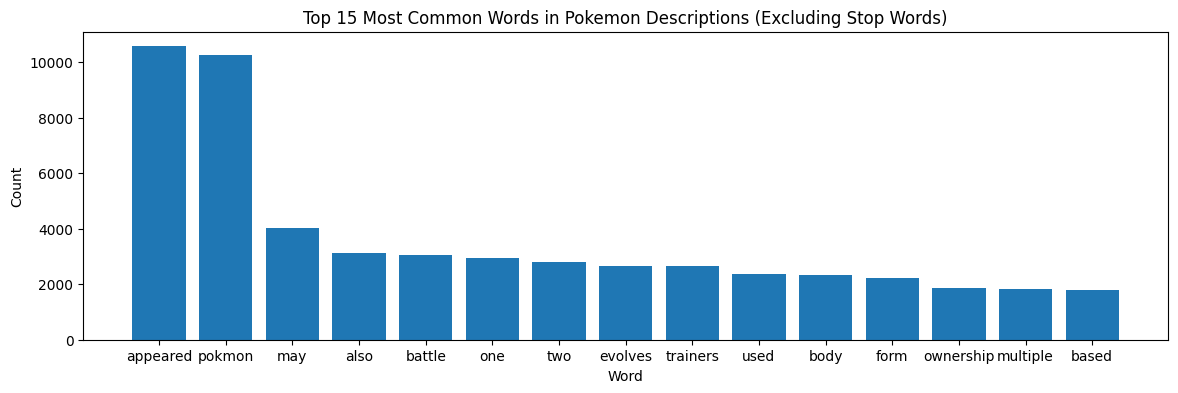

In [41]:
average_length = preprocessed_df['alphanumeric'].apply(len).mean()
print(f"\nAverage length of descriptions: {average_length:.2f} characters")

# Find the name of the Pokemon with the longest description
max_length_index = preprocessed_df['alphanumeric'].apply(len).idxmax()
max_length_pokemon_name = preprocessed_df.loc[max_length_index, 'name']
print(f"\nPokemon with the longest description: {max_length_pokemon_name}")

# Find the name of the Pokemon with the shortest description
min_length_index = preprocessed_df['alphanumeric'].apply(len).idxmin()
min_length_pokemon_name = preprocessed_df.loc[min_length_index, 'name']
print(f"Pokemon with the shortest description: {min_length_pokemon_name}")

# Tokenize the descriptions and remove stop words
stop_words = set(stopwords.words('english'))
all_words = [word.lower() for desc in preprocessed_df['alphanumeric'] for word in word_tokenize(desc) if word.lower() not in stop_words]
word_counts = Counter(all_words)

# Plot a bar chart of the most common words
plt.figure(figsize=(14, 4))
word_counts_df = pd.DataFrame(word_counts.most_common(15), columns=['Word', 'Count'])
plt.bar(word_counts_df['Word'], word_counts_df['Count'])
plt.title('Top 15 Most Common Words in Pokemon Descriptions (Excluding Stop Words)')
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

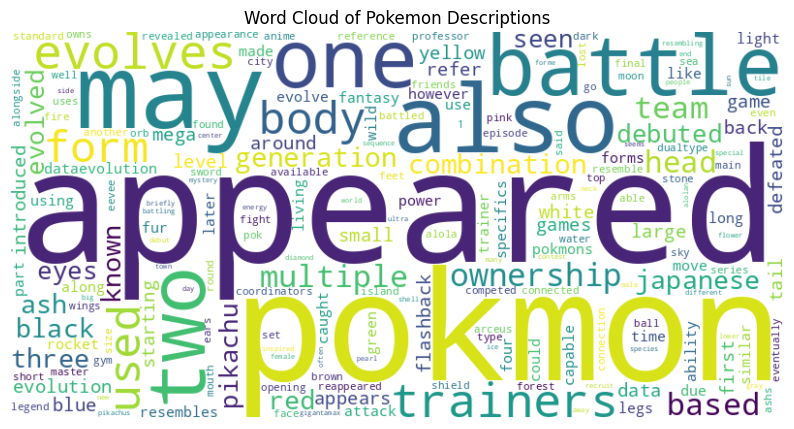

In [39]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Pokemon Descriptions')
plt.show()

The most common word is pokmon - because the alphanumeric doesn't include the letter é :)